In [43]:
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pandas as pd

base_path = "/home/hygo2025/Documents/data/processed_data/enriched_events_vix"



In [44]:
dataset = ds.dataset(base_path, format="parquet", partitioning="hive")
table = dataset.to_table()
df_vix = table.to_pandas()

print(df_vix.shape)
print(df_vix.columns.tolist())
df_vix.head()


(36234362, 20)
['listing_id', 'user_id', 'session_id', 'event_type', 'price', 'event_ts', 'event_id', 'platform', 'business_type', 'neighborhood', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms', 'suites', 'parking_spaces', 'amenities', 'usage_types', 'geopoint', 'dt']


,listing_id,user_id,session_id,event_type,price,event_ts,event_id,platform,business_type,neighborhood,usable_areas,total_areas,bathrooms,bedrooms,suites,parking_spaces,amenities,usage_types,geopoint,dt
0,54408,1034,543839,GalleryClicked,2650.0,2024-04-17 17:22:58.724,gallery-clicked-nf6hjk,MOBILE,RENTAL,jardim camburi,110.0,110.0,3.0,3.0,1.0,2.0,"['BALCONY', 'GARAGE', 'KITCHEN', 'SAFETY_CIRCU...",['RESIDENTIAL'],"-40.267894,-20.2599804",2024-04-18
1,54408,1034,543839,GalleryClicked,2650.0,2024-04-17 17:23:00.743,gallery-clicked-ud1drr,MOBILE,RENTAL,jardim camburi,110.0,110.0,3.0,3.0,1.0,2.0,"['BALCONY', 'GARAGE', 'KITCHEN', 'SAFETY_CIRCU...",['RESIDENTIAL'],"-40.267894,-20.2599804",2024-04-18
2,54408,1034,543839,GalleryClicked,2650.0,2024-04-17 17:23:07.347,gallery-clicked-pb01pw,MOBILE,RENTAL,jardim camburi,110.0,110.0,3.0,3.0,1.0,2.0,"['BALCONY', 'GARAGE', 'KITCHEN', 'SAFETY_CIRCU...",['RESIDENTIAL'],"-40.267894,-20.2599804",2024-04-18
3,54408,1034,543839,GalleryClicked,2650.0,2024-04-17 17:22:55.177,gallery-clicked-49gw1o,MOBILE,RENTAL,jardim camburi,110.0,110.0,3.0,3.0,1.0,2.0,"['BALCONY', 'GARAGE', 'KITCHEN', 'SAFETY_CIRCU...",['RESIDENTIAL'],"-40.267894,-20.2599804",2024-04-18
4,54408,1034,543839,GalleryClicked,2650.0,2024-04-17 17:23:03.785,gallery-clicked-6zuuj1,MOBILE,RENTAL,jardim camburi,110.0,110.0,3.0,3.0,1.0,2.0,"['BALCONY', 'GARAGE', 'KITCHEN', 'SAFETY_CIRCU...",['RESIDENTIAL'],"-40.267894,-20.2599804",2024-04-18


In [45]:
df_vix.columns

Index(['listing_id', 'user_id', 'session_id', 'event_type', 'price',
       'event_ts', 'event_id', 'platform', 'business_type', 'neighborhood',
       'usable_areas', 'total_areas', 'bathrooms', 'bedrooms', 'suites',
       'parking_spaces', 'amenities', 'usage_types', 'geopoint', 'dt'],
      dtype='object')

### Análise Exploratória de Dados (EDA)

In [46]:
unique_listings = df_vix["listing_id"].nunique()
unique_listings

8467

In [47]:
unique_users = df_vix["user_id"].nunique()
unique_users

448078

In [48]:
unique_events = df_vix["event_type"].nunique()
unique_events

9

In [49]:
unique_neighborhoods = df_vix["neighborhood"].nunique()
unique_neighborhoods

1

In [50]:
# Quantidade de eventos por bairro
events_per_neighborhood = df_vix.groupby("neighborhood").size().reset_index(name='event_count').sort_values(by='event_count', ascending=False)
events_per_neighborhood.head(10)

,neighborhood,event_count
0,jardim camburi,36234362


In [51]:
events_by_type_and_neighborhood = (
    df_vix
    .groupby(["neighborhood", "event_type"])
    .size()
    .reset_index(name="event_count")
    .pivot_table(
        index="neighborhood",
        columns="event_type",
        values="event_count",
        fill_value=0
    )
)

events_by_type_and_neighborhood["total_events"] = events_by_type_and_neighborhood.sum(axis=1)
events_by_type_and_neighborhood = events_by_type_and_neighborhood.sort_values("total_events", ascending=False)

events_by_type_and_neighborhood = events_by_type_and_neighborhood.reset_index()
events_by_type_and_neighborhood.head(10)

event_type,neighborhood,DecisionTreeFormClicked,FavoriteClicked,GalleryClicked,LeadClicked,LeadPanelClicked,ListingRendered,RankingClicked,RankingRendered,ShareClicked,total_events
0,jardim camburi,23387.0,16977.0,13145871.0,31718.0,1040111.0,826284.0,510175.0,20629423.0,10416.0,36234362.0


In [52]:
cols = ['listing_id', 'price', 'usable_areas', 'total_areas',
        'bathrooms', 'bedrooms', 'suites', 'parking_spaces', 'business_type']

df_num = df_vix[cols]

df_num = (
    df_vix.groupby('listing_id')
    .agg({
        'price': 'mean',          # média de preço
        'usable_areas': 'first',
        'total_areas': 'first',
        'bathrooms': 'first',
        'bedrooms': 'first',
        'suites': 'first',
        'parking_spaces': 'first',
        'business_type': 'first'
    })
    .reset_index()
)

df_num.sort_values('listing_id', ascending=True).head(10)


,listing_id,price,usable_areas,total_areas,bathrooms,bedrooms,suites,parking_spaces,business_type
0,8,690000.0,68.0,68.0,1.0,2.0,1.0,1.0,SALE
1,9,700000.0,60.0,60.0,2.0,2.0,1.0,2.0,SALE
2,14,2600000.0,213.0,213.0,1.0,4.0,2.0,3.0,SALE
3,15,4500.0,85.0,140.0,2.0,3.0,1.0,3.0,RENTAL
4,33,1050000.0,96.0,96.0,2.0,3.0,1.0,2.0,SALE
5,37,720000.0,62.0,NaN,2.0,2.0,1.0,2.0,SALE
6,39,650000.0,105.0,105.0,3.0,3.0,1.0,1.0,SALE
7,51,320000.0,50.0,NaN,1.0,2.0,NaN,1.0,SALE
8,53,2500.0,86.0,86.0,1.0,2.0,0.0,1.0,RENTAL
9,58,3800.0,86.0,86.0,3.0,3.0,1.0,2.0,RENTAL


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

def plot_distribution(df, column, category_col=None, category_val=None, bins=100):
    data = df.copy()
    if category_col and category_val:
        data = data[data[category_col] == category_val]

    data = data[data[column].notnull() & (data[column] > 0)]
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    sns.histplot(data=data, x=column, kde=True, bins=bins, ax=axs[0])
    axs[0].set_title(f'Distribuição de {column} (Escala Normal)', fontsize=13)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Frequência')

    sns.histplot(data=data, x=column, kde=True, bins=bins, log_scale=True, ax=axs[1])
    axs[1].set_title(f'Distribuição de {column} (Escala Logarítmica)', fontsize=13)
    axs[1].set_xlabel(column)
    axs[1].set_ylabel('Frequência')

    axs[1].xaxis.set_major_locator(LogLocator(base=10.0))
    axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()


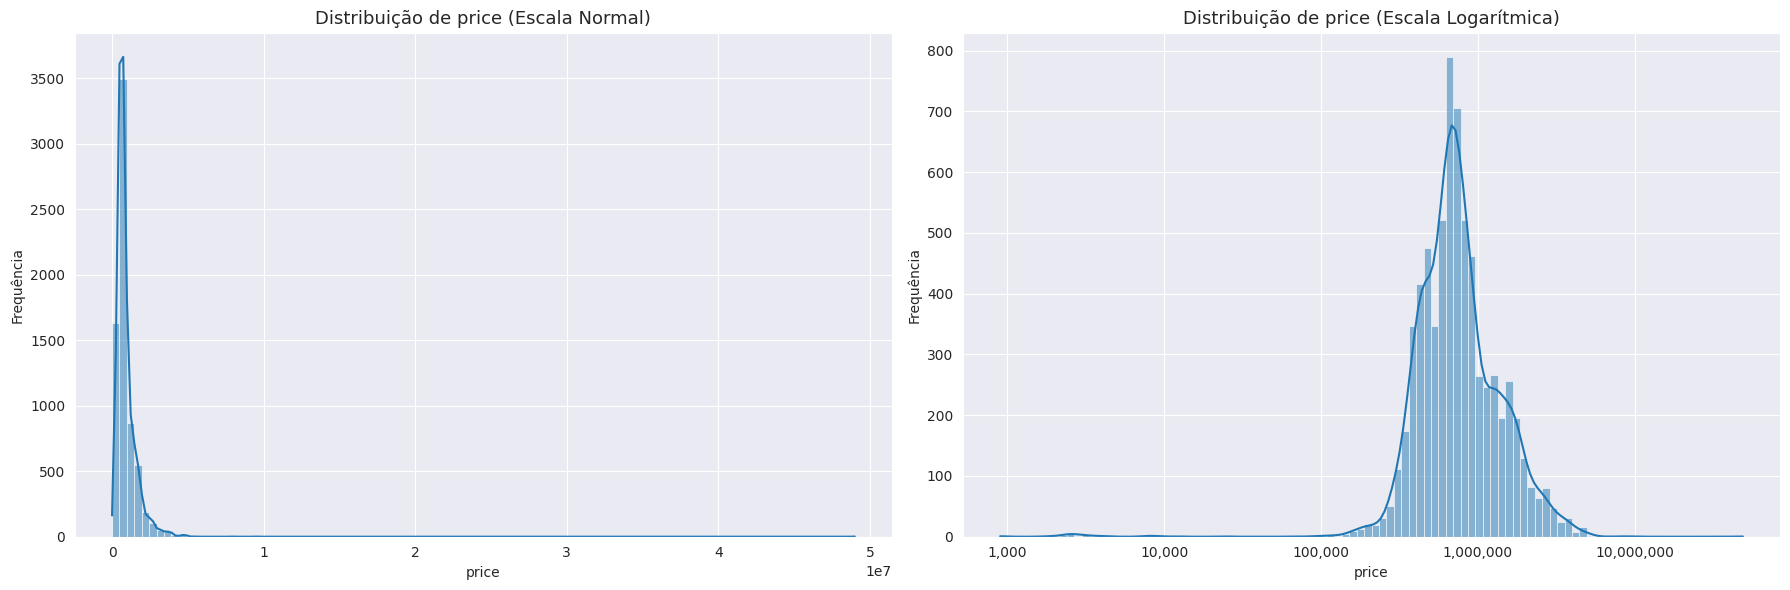

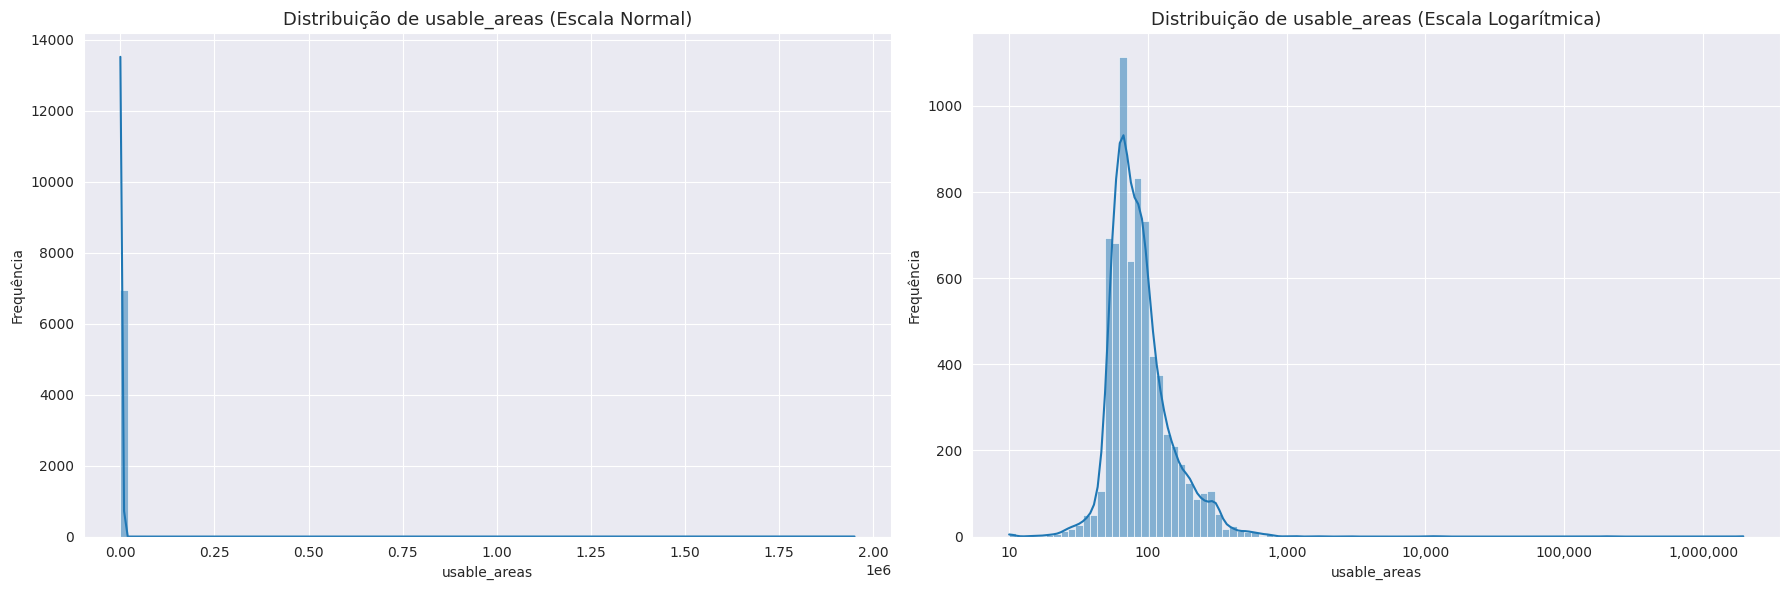

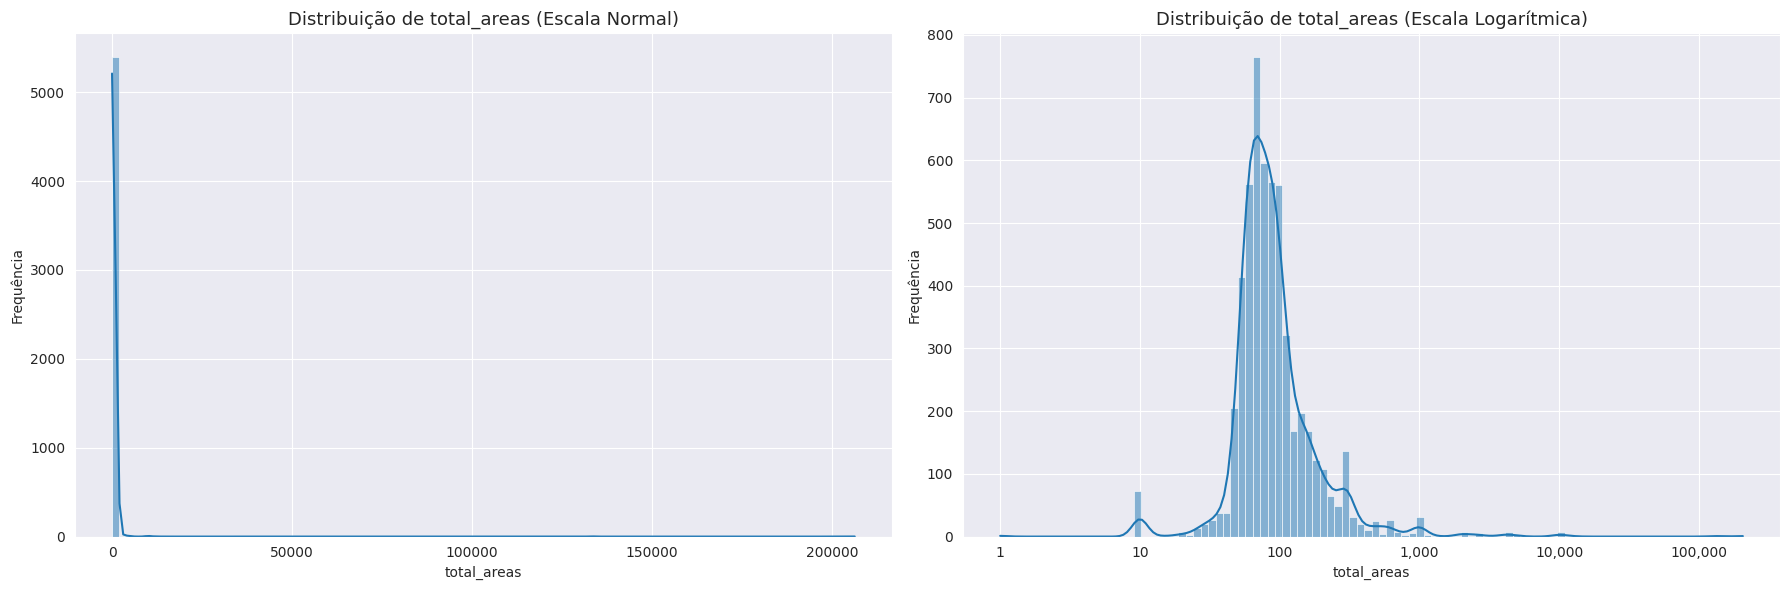

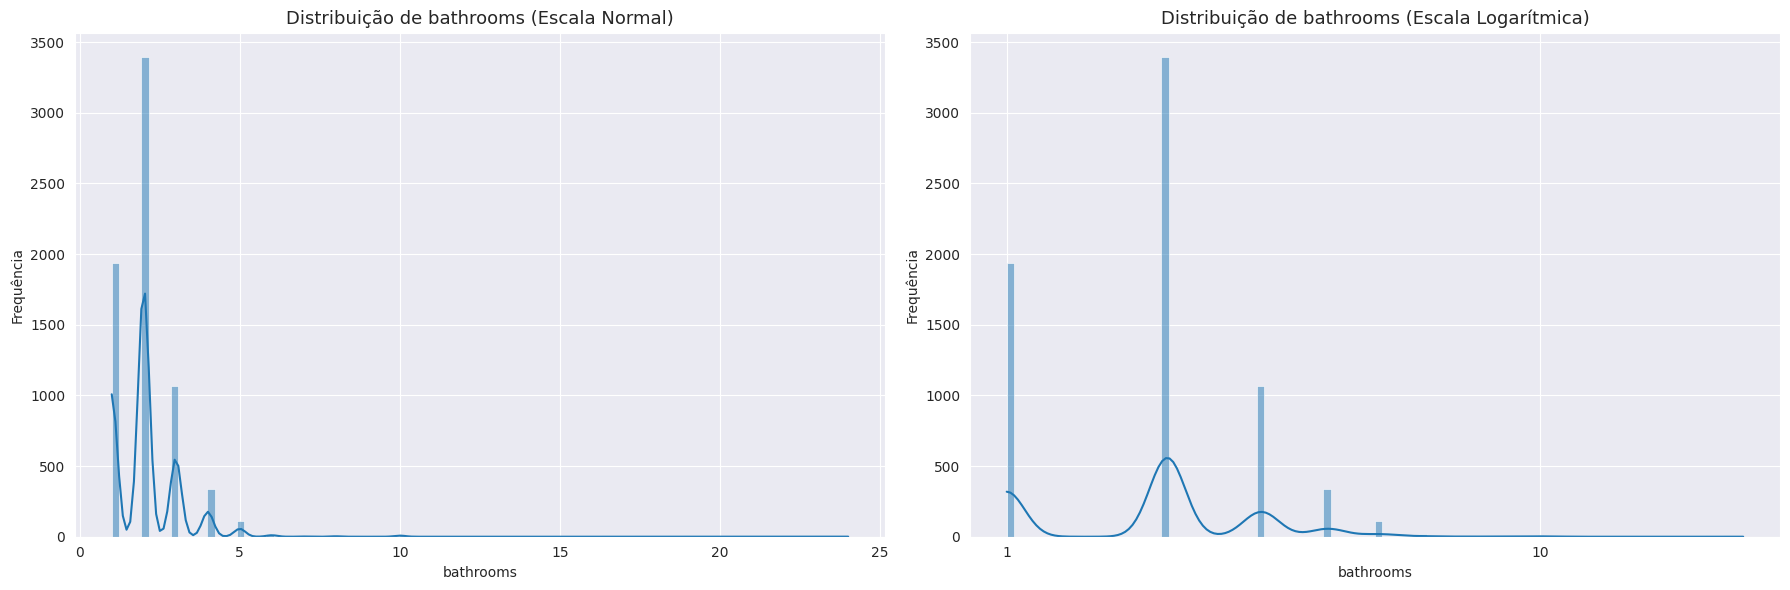

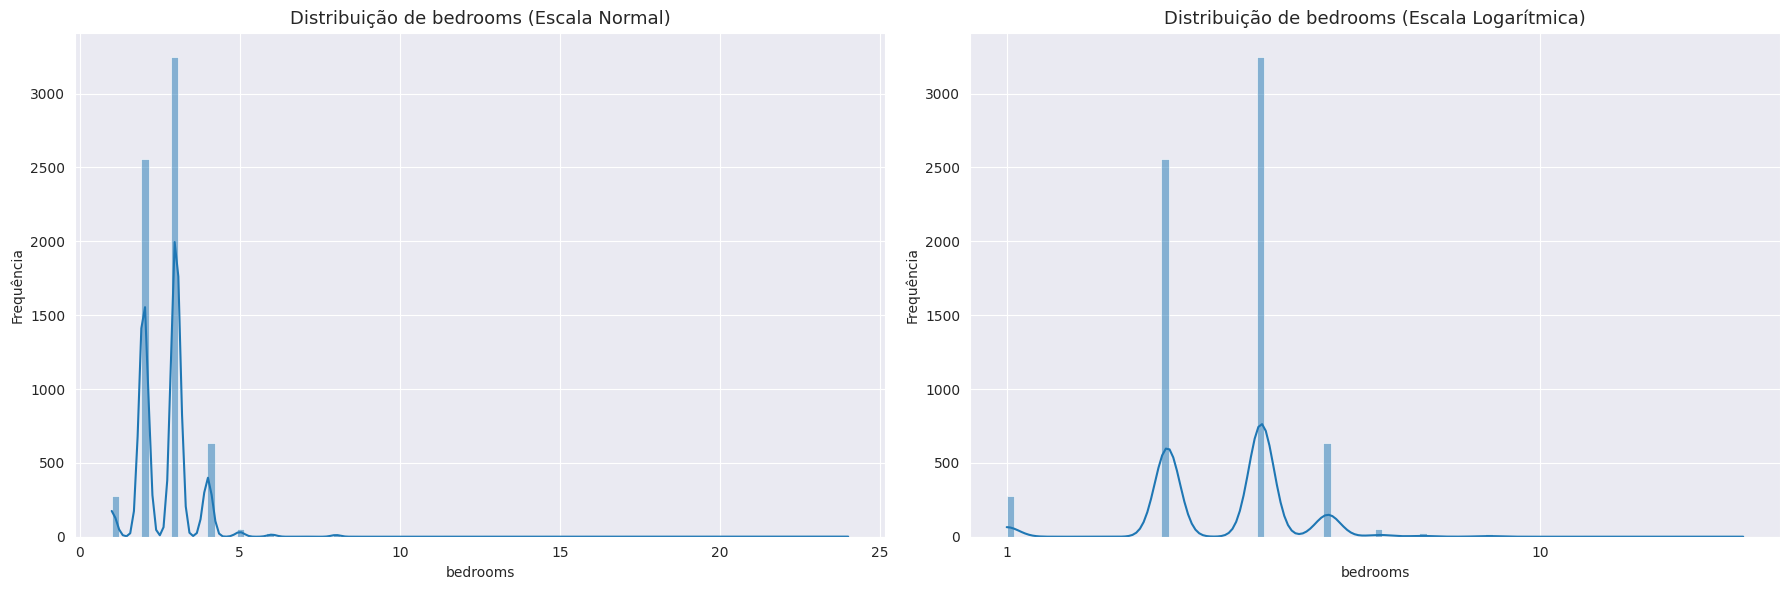

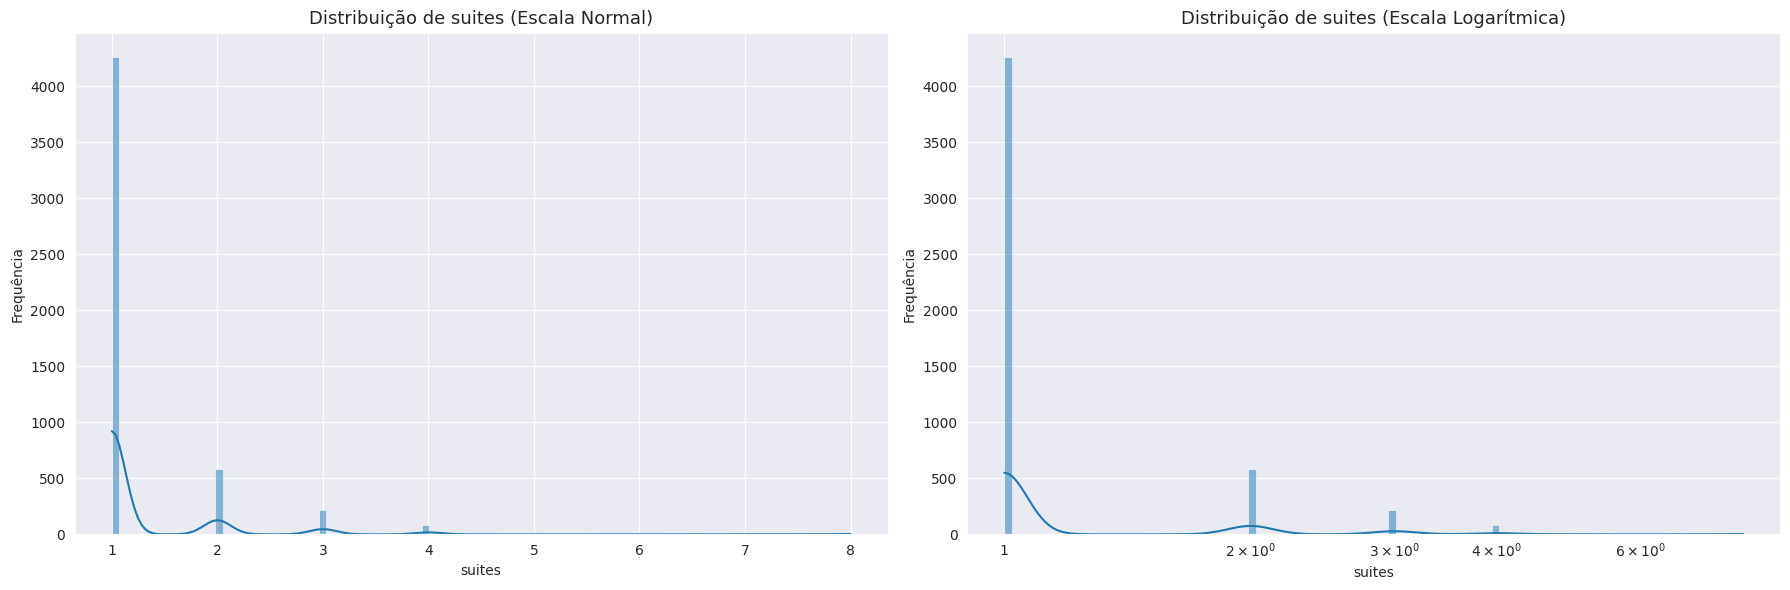

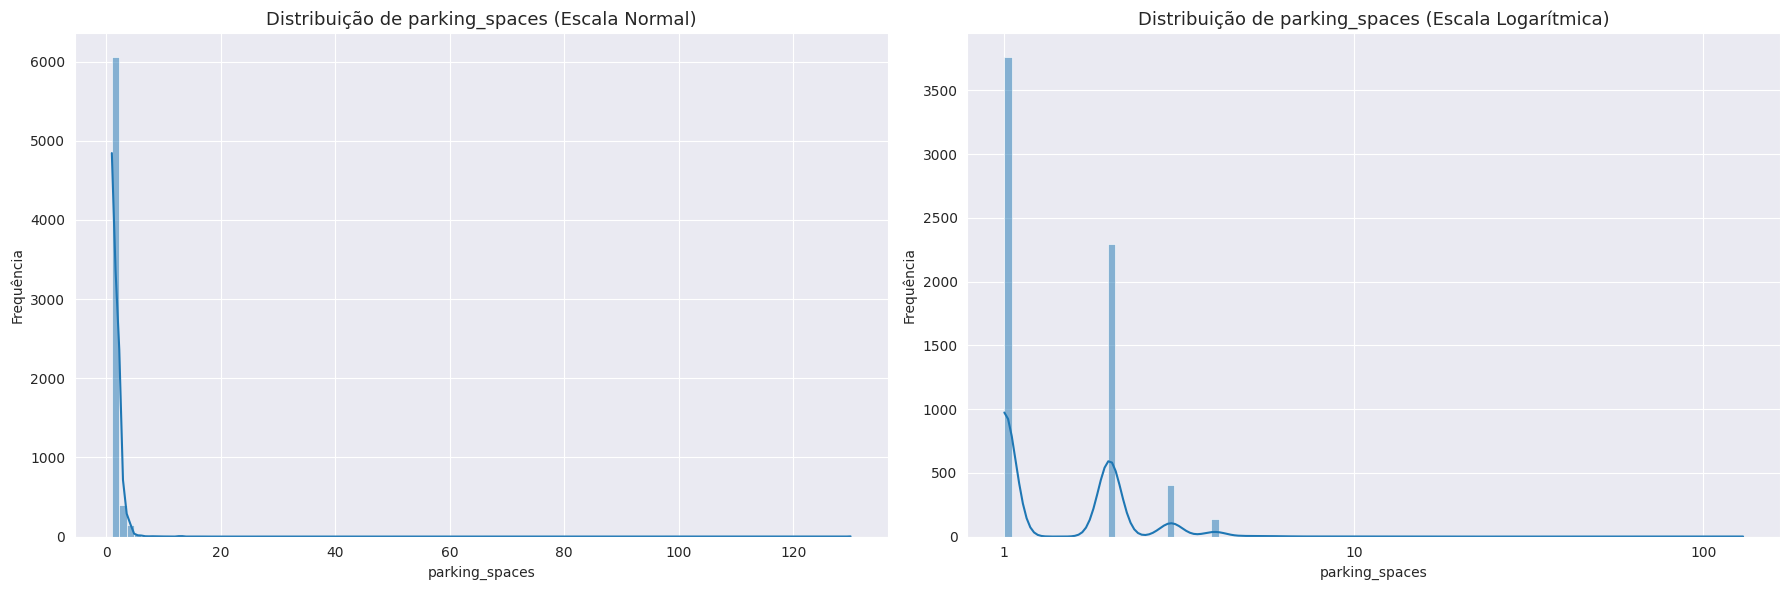

In [54]:
cols = ['price', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms', 'suites', 'parking_spaces']

for col in cols:
    plot_distribution(df_num, column=col, category_col='business_type', category_val='SALE')


In [55]:
df_feat_caract = df_num[['bedrooms', 'bathrooms' , 'parking_spaces', 'total_areas', 'usable_areas']].copy()
df_feat_caract.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,bedrooms,bathrooms,parking_spaces,total_areas,usable_areas
count,8414.00000,8453.00000,8254.00000,6760.00000,8467.00000
mean,2.48645,1.94795,1.49249,232.35488,352.88969
std,1.01539,1.03803,2.20914,4202.41746,21302.48966
min,0.00000,0.00000,0.00000,1.00000,0.00000
25%,2.00000,1.00000,1.00000,60.00000,60.00000
50%,3.00000,2.00000,1.00000,78.00000,76.00000
75%,3.00000,2.00000,2.00000,106.00000,104.00000
max,24.00000,24.00000,130.00000,206325.00000,1950000.00000


<Axes: xlabel='usable_areas'>

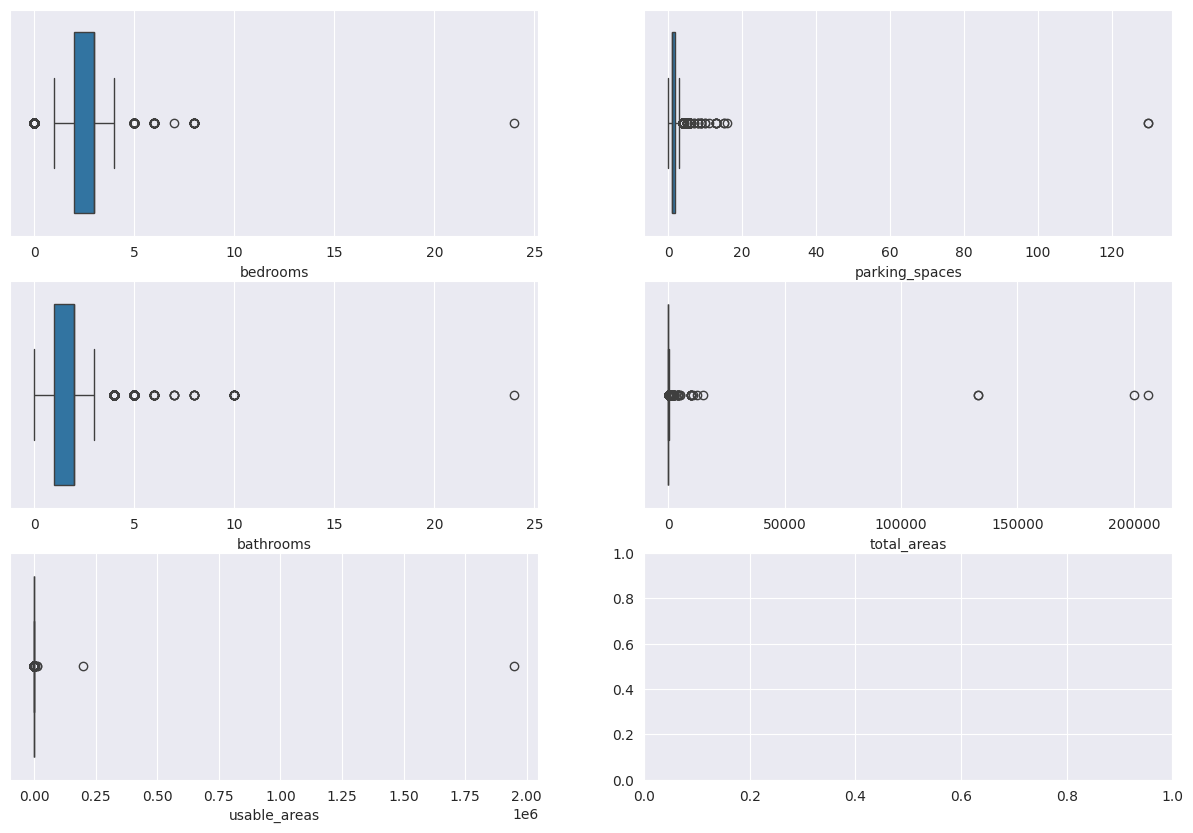

In [56]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))#, sharey=True)

sns.boxplot(x=df_feat_caract["bedrooms"], ax=axs[0, 0])
sns.boxplot(x=df_feat_caract["bathrooms"], ax=axs[1, 0])
sns.boxplot(x=df_feat_caract["parking_spaces"], ax=axs[0, 1])
sns.boxplot(x=df_feat_caract["total_areas"], ax=axs[1, 1])
sns.boxplot(x=df_feat_caract["usable_areas"], ax=axs[2, 0])

In [57]:
df_feat_caract.nunique()

bedrooms           10
bathrooms          11
parking_spaces     16
total_areas       315
usable_areas      298
dtype: int64